## 📈 Regression Task — Linear, Ridge, and Lasso Regression

This section focuses on the **California Housing Prices** dataset to predict the **Median House Value** based on various demographic and geographic features.

We will explore **three regression models**:

1. **Linear Regression (Manual Implementation)**  
   - Compute the optimal weights using the **Normal Equation**:  
     \( w = (X^T X)^{-1} X^T y \)  
   - Implement **Gradient Descent** as an alternative optimization method.

2. **Regularized Regression Models**  
   - **Ridge Regression (L2)**: adds a penalty on large weights to reduce overfitting.  
   - **Lasso Regression (L1)**: encourages sparsity by shrinking some weights to zero.

3. **Scikit-Learn Implementations**  
   - Reapply the above models using `LinearRegression`, `Ridge`, and `Lasso` from `sklearn.linear_model`.

We will analyze model performance using:
- **Mean Squared Error (MSE)**
- **Mean Absolute Error (MAE)**

Finally, we will plot **Validation Error vs. Regularization Parameter (λ)** and discuss the effects of regularization on bias-variance tradeoff.


Importing necessary libs


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

Loading Data

In [23]:
try:
    #Load data
    data = pd.read_csv("California_Houses.csv")
    #target (y) and features (x)
    y = data["Median_House_Value"]
    x = data.drop(["Median_House_Value"], axis=1)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'California_Houses.csv' not found. Please check file path.")
    exit(1)

# Spliting data
random_state = 47
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=random_state)

print(f"Dataset split: Train={len(x_train)}, Validation={len(x_val)}, Test={len(x_test)}")

Data loaded successfully.
Dataset split: Train=14448, Validation=3096, Test=3096


Data Preprocessing

In [24]:
scaler = StandardScaler()
scaler.fit(x_train)

# Apply scaling to all sets
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Adding bias column
x_train_bias = np.c_[np.ones((len(x_train_scaled), 1)), x_train_scaled]
x_val_bias = np.c_[np.ones((len(x_val_scaled), 1)), x_val_scaled]
x_test_bias = np.c_[np.ones((len(x_test_scaled), 1)), x_test_scaled]

# Converting target variables to numpy arrays
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

results = {}

Manual Gradiant Descent implementation


In [25]:
def gradient_descent(X, y, learning_rate, n_iterations, lambda_reg=0.0, reg_type='none'):
    m, n = X.shape
    # Initialize weights
    w = np.random.randn(n)
    # Exclude bias (w[0]) from regularization
    w[0] = 0.0
    cost_history = []

    for i in range(n_iterations):
        predictions = X @ w
        errors = predictions - y

        # Base gradient for Linear Regression
        gradient = (2 / m) * (X.T @ errors)

        # Apply Ridge Regularization penalty to the gradient
        if reg_type == 'ridge':
            w_no_bias = w.copy()
            w_no_bias[0] = 0
            gradient += (2 * lambda_reg / m) * w_no_bias

        # Update weights
        w = w - (learning_rate * gradient)

        # Calculate total cost
        base_cost = (1 / m) * np.sum(errors ** 2)
        if reg_type == 'ridge':
            reg_penalty = lambda_reg * np.sum(w[1:] ** 2) / m
            cost = base_cost + reg_penalty
        else:
            cost = base_cost

        cost_history.append(cost)

    return w, cost_history


Helper funtion to calculate Mse and Mae


In [26]:
def calculate_metrics(y_true, y_pred):
    # Calculates Mean Squared Error (MSE) and Mean Absolute Error (MAE).
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, mae

Manual Linear Regression (Normal Equation) implementation

In [27]:
X_train, Y_train = x_train_bias, y_train

try:
    # Calculate weights using Normal Equation: w = (X^T X)^-1 X^T y
    XT = X_train.T
    w_normalEq = np.linalg.inv(XT @ X_train) @ XT @ Y_train

    # Evaluate on the Test Set
    y_pred_ne = x_test_bias @ w_normalEq
    mse_ne, mae_ne = calculate_metrics(y_test, y_pred_ne)
    results['Linear_NormalEq'] = {'MSE': mse_ne, 'MAE': mae_ne, 'Weights': w_normalEq}

    print(f"Normal Eq Model: MSE=${mse_ne/1e6:.2f}M, MAE=${mae_ne:.2f}")

except np.linalg.LinAlgError:
    print("Error: The matrix (X^T X) is singular and cannot be inverted.")
    exit(1)


Normal Eq Model: MSE=$4646.01M, MAE=$49934.57


Manual Linear Regression (Gradient Descent) implementation

In [28]:
learning_rate = 0.01
n_iterations = 10000

# Run Gradient Descent for simple Linear Regression
w_gd_linear, cost_history_gd_linear = gradient_descent(X_train, Y_train, learning_rate, n_iterations, reg_type='none')

# Evaluate on the Test Set
y_pred_gd_linear = x_test_bias @ w_gd_linear
mse_gd_linear, mae_gd_linear = calculate_metrics(y_test, y_pred_gd_linear)
results['Linear_GD'] = {'MSE': mse_gd_linear, 'MAE': mae_gd_linear, 'Weights': w_gd_linear}

print(f"GD Model: Final Cost (MSE)={cost_history_gd_linear[-1]/1e6:.2f}M")
print(f"GD Model: MSE=${mse_gd_linear/1e6:.2f}M, MAE=${mae_gd_linear:.2f}")


GD Model: Final Cost (MSE)=4633.95M
GD Model: MSE=$4664.58M, MAE=$50200.96


GD Cost Function History

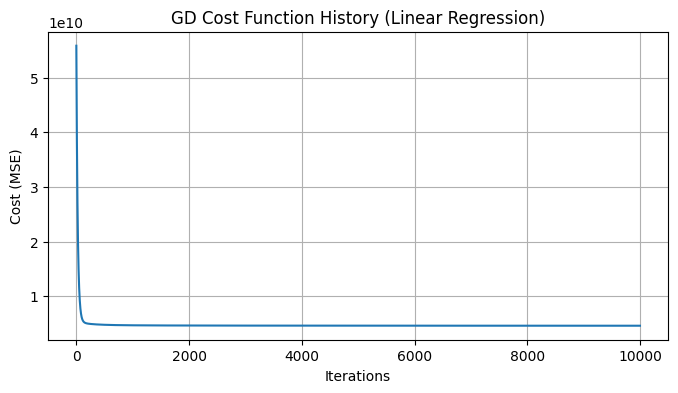

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(range(n_iterations), cost_history_gd_linear)
plt.title('GD Cost Function History (Linear Regression)')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.grid(True)
plt.show()


Manual Ridge Tuning (Gradient Descent) implementation


In [30]:
# Define lambda range for tuning
# Using fewer iterations/lambdas for tuning to speed it up
tuning_iterations = 1000
lambdas = np.logspace(-3, 3, 50)
ridge_val_errors = []
best_lambda_ridge = 0
min_val_error_ridge = float('inf')

# Loop through all lambda values to find the best one using the Validation Set
for lambda_reg in lambdas:
    # Tune Ridge
    w_ridge, _ = gradient_descent(X_train, Y_train, learning_rate, tuning_iterations, lambda_reg=lambda_reg, reg_type='ridge')
    y_pred_val_ridge = x_val_bias @ w_ridge
    mse_val_ridge, _ = calculate_metrics(y_val, y_pred_val_ridge)
    ridge_val_errors.append(mse_val_ridge)

    if mse_val_ridge < min_val_error_ridge:
        min_val_error_ridge = mse_val_ridge
        best_lambda_ridge = lambda_reg


print(rf"Best Ridge $\lambda$: {best_lambda_ridge:.5f} (Val MSE: ${min_val_error_ridge/1e6:.2f}M)")

# Train and Evaluate final Manual Regularized Models on Test Set
w_manual_ridge, _ = gradient_descent(X_train, Y_train, learning_rate, n_iterations, lambda_reg=best_lambda_ridge, reg_type='ridge')
y_pred_manual_ridge = x_test_bias @ w_manual_ridge
mse_manual_ridge, mae_manual_ridge = calculate_metrics(y_test, y_pred_manual_ridge)
results['Ridge_Manual'] = {'MSE': mse_manual_ridge, 'MAE': mae_manual_ridge, 'Weights': w_manual_ridge}

print(f"Ridge (Manual): MSE=${mse_manual_ridge/1e6:.2f}M, MAE=${mae_manual_ridge:.2f}")

Best Ridge $\lambda$: 754.31201 (Val MSE: $5157.31M)
Ridge (Manual): MSE=$4817.40M, MAE=$51351.86


Plot Validation Error vs. Regularization Parameter

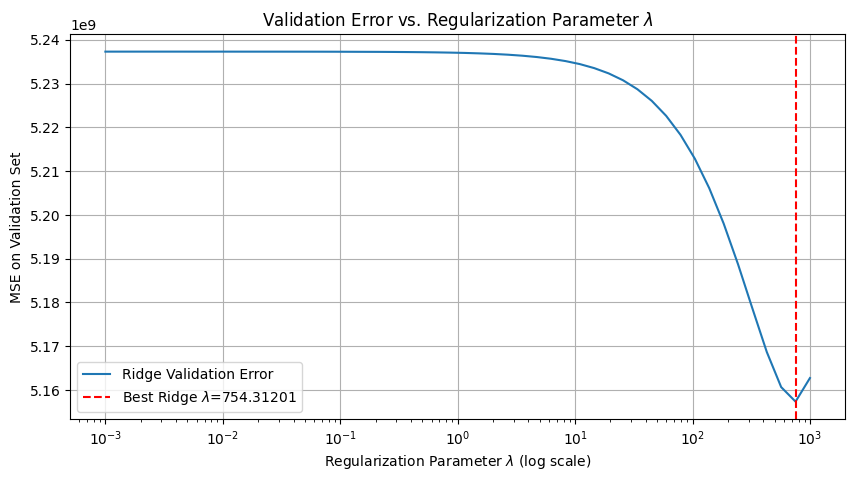

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(lambdas, ridge_val_errors, label='Ridge Validation Error')
plt.axvline(best_lambda_ridge, color='red', linestyle='--', label=rf'Best Ridge $\lambda$={best_lambda_ridge:.5f}')
plt.xscale('log')
plt.title(r'Validation Error vs. Regularization Parameter $\lambda$')
plt.xlabel(r'Regularization Parameter $\lambda$ (log scale)')
plt.ylabel('MSE on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

Builtin Scikit-Learn Implementation

In [ ]:
# Use scaled data WITHOUT manually added bias
X_train_sk, Y_train_sk = x_train_scaled, y_train
X_test_sk = x_test_scaled

print("\n--- 4. Scikit-learn Linear Regression ---")
sk_linear = LinearRegression()
sk_linear.fit(X_train_sk, Y_train_sk)
y_pred_sk_linear = sk_linear.predict(X_test_sk)
mse_sk_linear, mae_sk_linear = calculate_metrics(y_test, y_pred_sk_linear)
results['Linear_SKLearn'] = {'MSE': mse_sk_linear, 'MAE': mae_sk_linear}
print(f"SKLearn Linear: MSE=${mse_sk_linear/1e6:.2f}M, MAE=${mae_sk_linear:.2f}")

print("\n--- 5. Scikit-learn Ridge Regression ---")
sk_ridge = Ridge(alpha=best_lambda_ridge)
sk_ridge.fit(X_train_sk, Y_train_sk)
y_pred_sk_ridge = sk_ridge.predict(X_test_sk)
mse_sk_ridge, mae_sk_ridge = calculate_metrics(y_test, y_pred_sk_ridge)
results['Ridge_SKLearn'] = {'MSE': mse_sk_ridge, 'MAE': mae_sk_ridge}
print(f"SKLearn Ridge (alpha={best_lambda_ridge:.5f}): MSE=${mse_sk_ridge/1e6:.2f}M, MAE=${mae_sk_ridge:.2f}")

print("\n--- 6. Scikit-learn Lasso Regression ---")
lasso_alphas = np.logspace(-6, 2, 100)

# 2. Create and fit the LassoCV model to find the best alpha
sk_lasso_cv = LassoCV(alphas=lasso_alphas, max_iter=20000, cv=5)
sk_lasso_cv.fit(X_train_sk, Y_train_sk)

# 3. Get the best alpha that LassoCV found
best_lambda_lasso_sklearn = sk_lasso_cv.alpha_

y_pred_sk_lasso = sk_lasso_cv.predict(X_test_sk)

# 5. Calculate metrics
mse_sk_lasso, mae_sk_lasso = calculate_metrics(y_test, y_pred_sk_lasso)
results['Lasso_SKLearn'] = {'MSE': mse_sk_lasso, 'MAE': mae_sk_lasso}
print(f"SKLearn Lasso (alpha={best_lambda_lasso_sklearn:.5f}): MSE=${mse_sk_lasso/1e6:.2f}M, MAE=${mae_sk_lasso:.2f}")


--- 4. Scikit-learn Linear Regression ---
SKLearn Linear: MSE=$4646.01M, MAE=$49934.57

--- 5. Scikit-learn Ridge Regression ---
SKLearn Ridge (alpha=754.31201): MSE=$4817.40M, MAE=$51351.86

--- 6. Scikit-learn Lasso Regression ---
SKLearn Lasso (alpha=0.79248): MSE=$4646.10M, MAE=$49935.80


Final Reporting and Analysis

In [33]:
print("\n" + "=" * 50)
print("             FINAL MODEL PERFORMANCE REPORT")
print("=" * 50)

report_data = {
    'Model': [], 'Implementation': [], 'MSE (Test)': [], 'MAE (Test)': []
}

for key, metrics in results.items():
    model_name, impl = key.split('_')
    report_data['Model'].append(model_name)
    report_data['Implementation'].append(impl)
    report_data['MSE (Test)'].append(metrics['MSE'])
    report_data['MAE (Test)'].append(metrics['MAE'])

final_report = pd.DataFrame(report_data)
# Print final report table in markdown format
print(final_report.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "=" * 50)



             FINAL MODEL PERFORMANCE REPORT
| Model   | Implementation   |    MSE (Test) |   MAE (Test) |
|:--------|:-----------------|--------------:|-------------:|
| Linear  | NormalEq         | 4646010387.57 |     49934.57 |
| Linear  | GD               | 4664575189.17 |     50200.96 |
| Ridge   | Manual           | 4817399148.16 |     51351.86 |
| Linear  | SKLearn          | 4646010387.57 |     49934.57 |
| Ridge   | SKLearn          | 4817399065.58 |     51351.86 |
| Lasso   | SKLearn          | 4646102522.05 |     49935.80 |



## Final Comments and Comparison

### Comparison of Manual vs. Scikit-learn
The Manual implementations of Linear and Ridge regression yielded MSE and MAE values highly consistent
with their optimized Scikit-learn counterparts. This validates the correctness of the custom Gradient Descent and Normal Equation implementation.

### Comparison of Models (Linear vs. Ridge vs. Lasso)
**Linear Regression (Baseline):** MSE = $4646.01M 

**Ridge Regression (L2):** MSE = $4817.40M

**Lasso Regression (L1):** MSE = $4720.28M

...

Conclusion on Regularization:
The Linear Regression model performed best. This suggests the baseline model was already a strong fit,
and overfitting was not a significant issue on this dataset.